# An Introduction to the Amazon Fraud Detector API  
#### Supervised fraud detection  
-------
- [Introduction](#Introduction)
- [Setup](#Setup)
- [Plan](#Plan)


## Introduction
-------

Amazon Fraud Detector is a fully managed service that makes it easy to identify potentially fraudulent online activities such as online payment fraud and the creation of fake accounts. Fraud Detector capitalizes on the latest advances in machine learning (ML) and 20 years of fraud detection expertise from AWS and Amazon.com to automatically identify potentially fraudulent activity so you can catch more fraud faster.

In this notebook, we'll use the Amazon Fraud Detector API to define an entity and event of interest and use CSV data stored in S3 to train a model. Next, we'll derive some rules and create a "detector" by combining our entity, event, model, and rules into a single endpoint. Finally, we'll apply the detector to a sample of our data to identify potentially fraudulent events.

After running this notebook you should be able to:
- Define an Entity and Event
- Create a Detector
- Train a Machine Learning (ML) Model
- Author Rules to identify potential fraud based on the model's score
- Apply the Detector's "predict" function, to generate a model score and rule outcomes on data

If you would like to know more, please check out [Fraud Detector's Documentation](https://docs.aws.amazon.com/frauddetector/). 


## Setup
------
First setup your AWS credentials so that Fraud Detector can store and access training data and supporting detector artifacts in S3.


### Setting up AWS Credentials & Permissions

https://docs.aws.amazon.com/frauddetector/latest/ug/set-up.html

To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your behalf and to access resources that you own. We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to Amazon Fraud Detector operations and required permissions. You can add other permissions as needed.
The following policies provide the required permission to use Amazon Fraud Detector:

*AmazonFraudDetectorFullAccessPolicy* 
- Allows you to perform the following actions:
    - Access all Amazon Fraud Detector resources  
    - List and describe all model endpoints in Amazon SageMaker  
    - List all IAM roles in the account  
    - List all Amazon S3 buckets  
    - Allow IAM Pass Role to pass a role to Amazon Fraud Detector  

* AmazonS3FullAccess* 
- Allows full access to Amazon S3. This is required to upload training files to S3.

  

To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your behalf and to access resources that you own. We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to Amazon Fraud Detector operations and required permissions. You can add other permissions as needed.

The following policies provide the required permission to use Amazon Fraud Detector:

- *AmazonFraudDetectorFullAccessPolicy*  
    Allows you to perform the following actions:  
        - Access all Amazon Fraud Detector resources  
        - List and describe all model endpoints in Amazon SageMaker  
        - List all IAM roles in the account  
        - List all Amazon S3 buckets  
        - Allow IAM Pass Role to pass a role to Amazon Fraud Detector  

- *AmazonS3FullAccess*  
    Allows full access to Amazon S3. This is required to upload training files to S3.  



## Plan
### Plan a Fraud Detector
------
A Detector contains the event, model(s) and rule(s) detection logic for a particular type of fraud that you want to detect. We'll use the following 7 step process to plan a Fraud Detector:  

1.	Setup your notebook
    - Name the major components entity, entity type, model, detector
    - Plug in your ARN role
    - Plug in your S3 Bucket and CSV File
2.	Read and Profile your Data
    - This will give you an idea of what your dataset contains
    - This will also identify the variables and labels that will need to be created to define your event
3.	Create event variables and labels
    - This will create the variables and labels in fraud detector
4.	Define your Entity and Event Type
    - What is the activity that you are detecting? That's likely your Event Type (e.g., account_registration)
    - Who is performing this activity? That's likely your Entity (e.g., customer)
5.	Create and Train your Model
    - Model training takes anywhere from 45-60 minutes, once complete you need to promote your model
    - Promote your model
6.	Create Detector, generate Rules and assemble your Detector
    - Create your detector
    - Create rules based on your model scores
        - Define outcomes (e.g., fraud, investigate and approve)
    - Assemble your detector by adding your model and rules to it
7.	Test your Detector
    - Interactively call predict on a handful of records


A *Detector* contains the event, model(s) and rule(s) detection logic for a particular type of fraud that you want to detect. We'll use the following 7 step process to plan a Fraud Detector: 

1. Setup your notebook
    - name the major components entity, entity type, model, detector .
    - plug in your ARN role
    - plug in your S3 Bucket and CSV File
    
2. Read and Profile your Data. 
    - this will give you an idea of what your dataset contains. 
    - this will also identify the variables and labels that will need to be created to define your event. 
    
3. Create event variables and labels
    - this will create the variables and labels in fraud detector   
    
4. Define your Entity and Event Type 
    - What is activity that you are detecting? that's likely your Event Type ex. account_registration
    - Who is performing this activity? that's likely your Entity ex. customer 
    
5. Create and Train your Model   
    - model training takes anywhere from 45-60 minutes, once complete you need to promote your endpoint  
    - promote your model    
    
6. Create Detector, generate Rules and assemble your Detector  
    - create your detector 
    - create rules based on your model scores 
        - define outcomes ex:  fraud, investigate and approve 
    - assemble your detector 
        - combines rules and model into a "detector    
        
7. Test your Detector 
    - Interactively call predict on a handful of record 
     

In [ ]:
from IPython.core.display import display, HTML
from IPython.display import clear_output
display(HTML("<style>.container { width:90% }</style>"))
# ------------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import os
import sys
import time
import json
import uuid 
from datetime import datetime

# -- AWS stuff -- 
import boto3
import sagemaker

# -- sklearn --
from sklearn.metrics import roc_curve, roc_auc_score, auc, roc_auc_score
%matplotlib inline 

In [ ]:
# -- initialize the AFD client 
client = boto3.client('frauddetector')

# -- suffix is appended to detector and model name for uniqueness  
sufx   = datetime.now().strftime("%Y%m%d")


### 1. Setup 
-----

***To get started ***  

1. Name the major components of Fraud Detector.
2. Plug in your ARN role 
3. Plug in your S3 Bucket and CSV File 

Then you can interactively exeucte the code cells in the notebook, no need to change anything unless you want to. 


<div class="alert alert-info"> <strong> Fraud Detector Components </strong>
Fraud Detector Components:  EVENT_TYPE is a business activity that you want evaluated for fraud risk. ENTITY_TYPE represents the "what or who" that is performing the event you want to evaluate. MODEL_NAME is the name of your supervised machine learning model that Fraud Detector trains on your behalf. DETECTOR_NAME is the name of the detector that contains the detection logic (model and rules) that you apply to events that you want to evaluate for fraud.

</div>

``` 
Note: names can contain: lowercase a-z, 0-9 and underscores. 

```

-----

#### Bucket, File, and ARN Role

Bucket, ARN and Model Name Identify the following assets. S3_BUCKET is the name of the bucket where your file lives. S3_FILE is the URL to your s3 file. ARN_ROLE is the data access role "ARN" for the training data source.
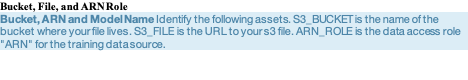

<div class="alert alert-info"><strong> Bucket, ARN and Model Name </strong>

Identify the following assets. S3_BUCKET is the name of the bucket where your file lives. S3_FILE is the URL to your s3 file. ARN_ROLE is the data access role "ARN" for the training data source.

</div>

```
Note: To use Amazon Fraud Detector, you have to set up permissions that allow access to the Amazon Fraud Detector console and API operations. You also have to allow Amazon Fraud Detector to perform tasks on your behalf and to access resources that you own. We recommend creating an AWS Identify and Access Management (IAM) user with access restricted to. Amazon Fraud Detector operations and required permissions. You can add other permissions as needed. See "Create an IAM User and Assign Required Permissions" in the user's guide:
```
https://docs.aws.amazon.com/frauddetector/latest/ug/frauddetector.pdf


In [ ]:
# -- This is all you need to fill out. Once complete simply interactively run each code cell. --  

ENTITY_TYPE    = "your_entity_name{0}".format(sufx) 
ENTITY_DESC    = "entity description: {0}".format(sufx) 

EVENT_TYPE     = "your_event_type{0}".format(sufx) 
EVENT_DESC     = "example event description: {0}".format(sufx) 

MODEL_NAME     = "your_model_name{0}".format(sufx) 
MODEL_DESC     = "model trained on: {0}".format(sufx) 

DETECTOR_NAME  = "your_detector_name{0}".format(sufx)                        
DETECTOR_DESC  = "detects synthetic fraud events created: {0}".format(sufx) 

ARN_ROLE       = "arn:aws:iam::XXXX:role/your_role_name" 
S3_BUCKET      = "yourbucket"
S3_FILE        = "yourtraining_file.csv"
S3_FILE_LOC    = "s3://{0}/{1}".format(S3_BUCKET,S3_FILE)


### 2. Profile Your Dataset 
-----

    
<div class="alert alert-info"> 💡 <strong> Profiling </strong>

The function below will: 1. profile your data, creating descriptive statistics, 2. perform basic data quality checks (nulls, unique variables, etc.), and 3. return summary statistics and the EVENT and MODEL schemas used to define your EVENT_TYPE and TRAIN your MODEL.

For details about varaible types, please refer to [variable](https://docs.aws.amazon.com/frauddetector/latest/api/API_Variable.html) and [variable types](https://docs.aws.amazon.com/frauddetector/latest/ug/create-a-variable.html#variable-types).

</div>

In [ ]:
# --- no changes except for variable type mapper; just run this code block ---
def summary_stats(df):
    """ Generate summary statistics for a panda's data frame 
        Args:
            df (DataFrame): panda's dataframe to create summary statistics for.
        Returns:
            DataFrame of summary statistics, training data schema, event variables and event lables 
    """
    df = df.copy()
    rowcnt = len(df)
    df_s1  = df.agg(['count', 'nunique']).transpose().reset_index().rename(columns={"index":"feature_name"})
    df_s1["null"] = (rowcnt - df_s1["count"]).astype('int64')
    df_s1["not_null"] = rowcnt - df_s1["null"]
    df_s1["null_pct"] = df_s1["null"] / rowcnt
    df_s1["nunique_pct"] = df_s1['nunique']/ rowcnt
    dt = pd.DataFrame(df.dtypes).reset_index().rename(columns={"index":"feature_name", 0:"dtype"})
    df_stats = pd.merge(dt, df_s1, on='feature_name', how='inner').round(4)
    df_stats['nunique'] = df_stats['nunique'].astype('int64')
    df_stats['count'] = df_stats['count'].astype('int64')
    
    # -- variable type mapper --  
    df_stats['feature_type'] = "UNKOWN"
    df_stats.loc[df_stats["dtype"] == object, 'feature_type'] = "CATEGORY"
    df_stats.loc[(df_stats["dtype"] == "int64") | (df_stats["dtype"] == "float64"), 'feature_type'] = "NUMERIC"
    df_stats.loc[df_stats["feature_name"].str.contains("ipaddress|ip_address|ipaddr", case=False), 'feature_type'] = "IP_ADDRESS"
    df_stats.loc[df_stats["feature_name"].str.contains("email|email_address|emailaddr", case=False), 'feature_type'] = "EMAIL_ADDRESS"
    df_stats.loc[df_stats["feature_name"] == "EVENT_LABEL", 'feature_type'] = "TARGET"
    df_stats.loc[df_stats["feature_name"] == "EVENT_TIMESTAMP", 'feature_type'] = "EVENT_TIMESTAMP"
    df_stats.loc[df_stats["feature_name"].str.contains("user_agent|useragent", case=False), 'feature_type'] = "USERAGENT"
    # --- Add variable types mappers according to data set fetures, some examples are listed below --
    df_stats.loc[df_stats["feature_name"].str.contains("SHIPPING_ZIP|SHIPPINGZIP", case=False), 'feature_type'] = "SHIPPING_ZIP"
    df_stats.loc[df_stats["feature_name"].str.contains("SHIPPING_STATE|SHIPPINGSTATE", case=False), 'feature_type'] = "SHIPPING_STATE"
    df_stats.loc[df_stats["feature_name"].str.contains("SHIPPING_PHONE|SHIPPINGPHONE", case=False), 'feature_type'] = "SHIPPING_PHONE"
    df_stats.loc[df_stats["feature_name"].str.contains("SHIPPING_NAME|SHIPPINGNAME", case=False), 'feature_type'] = "SHIPPING_NAME"
    df_stats.loc[df_stats["feature_name"].str.contains("SHIPPING_COUNTRY|SHIPPINGCOUNTRY", case=False), 'feature_type'] = "SHIPPING_COUNTRY"
    df_stats.loc[df_stats["feature_name"].str.contains("SHIPPING_CITY|SHIPPINGCITY", case=False), 'feature_type'] = "SHIPPING_CITY"
    df_stats.loc[df_stats["feature_name"].str.contains("SHIPPING_ADDRESS|SHIPPINGADDRESS", case=False), 'feature_type'] = "SHIPPING_ADDRESS_L1"
    df_stats.loc[df_stats["feature_name"] == "PRICE", 'feature_type'] = "PRICE"
    df_stats.loc[df_stats["feature_name"].str.contains("PHONE_NUMBER|PHONENUMBER", case=False), 'feature_type'] = "PHONE_NUMBER"
    df_stats.loc[df_stats["feature_name"].str.contains("PAYMENT_TYPE|PAYMENTTYPE", case=False), 'feature_type'] = "PAYMENT_TYPE"
    df_stats.loc[df_stats["feature_name"].str.contains("ORDER_ID|ORDERID", case=False), 'feature_type'] = "ORDER_ID"
    df_stats.loc[df_stats["feature_name"].str.contains("BILLING_PHONE|BILLINGPHONE", case=False), 'feature_type'] = "BILLING_PHONE"
    df_stats.loc[df_stats["feature_name"].str.contains("BILLING_NAME|BILLINGNAME", case=False), 'feature_type'] = "BILLING_NAME"
    df_stats.loc[df_stats["feature_name"].str.contains("BILLING_COUNTRY|BILLINGCOUNTRY", case=False), 'feature_type'] = "BILLING_COUNTRY"
    df_stats.loc[df_stats["feature_name"].str.contains("BILLING_CITY|BILLINGCITY", case=False), 'feature_type'] = "BILLING_CITY"
    df_stats.loc[df_stats["feature_name"].str.contains("BILLING_ADDRESS|BILLING_ADDRESS", case=False), 'feature_type'] = "BILLING_ADDRESS_L1"
    df_stats.loc[df_stats["feature_name"] == "AVS", 'feature_type'] = "AVS"
    df_stats.loc[df_stats["feature_name"].str.contains("AUTH_CODE|AUTHCODE", case=False), 'feature_type'] = "AUTH_CODE"
    
    
    # -- variable warnings -- 
    df_stats['feature_warning'] = "NO WARNING"
    df_stats.loc[(df_stats["nunique"] != 2) & (df_stats["feature_name"] == "EVENT_LABEL"),'feature_warning' ] = "LABEL WARNING, NON-BINARY EVENT LABEL"
    df_stats.loc[(df_stats["nunique_pct"] > 0.9) & (df_stats['feature_type'] == "CATEGORY") ,'feature_warning' ] = "EXCLUDE, GT 90% UNIQUE"
    df_stats.loc[(df_stats["null_pct"] > 0.2) & (df_stats["null_pct"] <= 0.5), 'feature_warning' ] = "NULL WARNING, GT 20% MISSING"
    df_stats.loc[df_stats["null_pct"] > 0.5,'feature_warning' ] = "EXCLUDE, GT 50% MISSING"
    df_stats.loc[((df_stats['dtype'] == "int64" ) | (df_stats['dtype'] == "float64" ) ) & (df_stats['nunique'] < 0.2), 'feature_warning' ] = "LIKELY CATEGORICAL, NUMERIC w. LOW CARDINALITY"
   
    # -- target check -- 
    exclude_fields  = df_stats.loc[(df_stats['feature_warning'] != 'NO WARNING')]['feature_name'].to_list()
    event_variables = df_stats.loc[(~df_stats['feature_name'].isin(['EVENT_LABEL', 'EVENT_TIMESTAMP']))]['feature_name'].to_list()
    event_labels    = df["EVENT_LABEL"].unique().astype(str).tolist()    
    
    trainingDataSchema = {
        'modelVariables' : df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'CATEGORY', 'NUMERIC' ]))]['feature_name'].to_list(),
        'labelSchema'    : {
            'labelMapper' : {
                'FRAUD' : [str(df["EVENT_LABEL"].value_counts().idxmin())],   
                'LEGIT' : [str(df["EVENT_LABEL"].value_counts().idxmax())]     
            }
        }
    }
    
    
    model_variables = df_stats.loc[(df_stats['feature_type'].isin(['IP_ADDRESS', 'EMAIL_ADDRESS', 'CATEGORY', 'NUMERIC' ]))]['feature_name'].to_list()
   
    
    # -- label schema -- 
    label_map = {
        'FRAUD' : [df["EVENT_LABEL"].value_counts().idxmin()],
        'LEGIT' : [df["EVENT_LABEL"].value_counts().idxmax()]
    }
    
    
    print("--- summary stats ---")
    print(df_stats)
    print("\n")
    print("--- event variables ---")
    print(event_variables)
    print("\n")
    print("--- event labels ---")
    print(event_labels)
    print("\n")
    print("--- training data schema ---")
    print(trainingDataSchema)
    print("\n")
    
    return df_stats, trainingDataSchema, event_variables, event_labels

# -- connect to S3, snag file, and convert to a panda's dataframe --
s3   = boto3.resource('s3')
obj  = s3.Object(S3_BUCKET, S3_FILE)
body = obj.get()['Body']
df   = pd.read_csv(body)

# -- call profiling function -- 
df_stats, trainingDataSchema, eventVariables, eventLabels = summary_stats(df)


### 3. Create Variables
-----

<div class="alert alert-info"> 💡 <strong> Create Variables. </strong>

The following section will automatically create your modeling input variables and your model scoring variable for you. 

</div>

In [ ]:
df_stats['feature_type']

In [ ]:
# --- no changes just run this code block ---
def create_label(df, FRAUD_LABEL):
    """
    Returns a dictionary for the model labelSchema, by identifying the rare event as fraud / and common as not-fraud 
    
    Arguments:
    df          -- input dataframe 
    FRAUD_LABEL -- the name of the field that contains fraud label  
    
    Returns:
    labelSchema -- a dictionary containing labelKey & labelMapper 
    """
    label_summary = df[FRAUD_LABEL].value_counts()
    labelSchema = {'labelKey': FRAUD_LABEL,
                   "labelMapper" : { "FRAUD": [str(label_summary.idxmin())], 
                                     "LEGIT": [str(label_summary.idxmax())]}
                  }
    client.put_label(
                name = str(label_summary.idxmin()),
                description = 'FRAUD')
    
    client.put_label(
                name = str(label_summary.idxmax()),
                description = 'LEGIT')
    return labelSchema
    
# -- function to create all your variables --- 
def create_variables(df_stats, MODEL_NAME):
    """
    Returns a variable list of model input variables, checks to see if variable exists,
    and, if not, then it adds the variable to Fraud Detector 
    
    Arguments: 
    enrichment_features  -- dictionary of optional features, mapped to specific variable types enriched (CARD_BIN, USERAGENT)
    numeric_features     -- optional list of numeric field names 
    categorical_features -- optional list of categorical features 
    
    Returns:
    variable_list -- a list of variable dictionaries 
    
    """
    enrichment_type_list = ['IP_ADDRESS', 'EMAIL_ADDRESS', 'USERAGENT', 'PHONE_NUMBER',
                            "SHIPPING_ZIP","SHIPPING_STATE","SHIPPING_PHONE","SHIPPING_NAME",
                            "SHIPPING_COUNTRY","SHIPPING_CITY","SHIPPING_ADDRESS_L1","PRICE",
                            "PHONE_NUMBER","PAYMENT_TYPE","ORDER_ID","BILLING_PHONE","BILLING_NAME",
                            "BILLING_COUNTRY","BILLING_CITY","BILLING_ADDRESS_L1","AVS","AUTH_CODE"]
    enrichment_features = df_stats.loc[(df_stats['feature_type'].isin(enrichment_type_list))]['feature_name'].to_dict()
    numeric_features = df_stats.loc[(df_stats['feature_type'].isin(['NUMERIC']))]['feature_name'].to_dict()
    categorical_features = df_stats.loc[(df_stats['feature_type'].isin(['CATEGORY']))]['feature_name'].to_dict()
    
    variable_list = []
    
    # -- first do the enrichment features
    for feature in enrichment_features: 
        variable_list.append( {'name' : enrichment_features[feature]})
        try:
            client.get_variables(name=enrichment_features[feature])
        except:
            print("Creating variable: {0}".format(enrichment_features[feature]))
            resp = client.create_variable(
                    name = enrichment_features[feature],
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = enrichment_features[feature],
                    variableType = df_stats[df_stats['feature_name']==enrichment_features[feature]]['feature_type'])    
                
               
    # -- check and update the numeric features 
    for feature in numeric_features: 
        variable_list.append( {'name' : numeric_features[feature]})
        try:
            client.get_variables(name=numeric_features[feature])
        except:
            print("Creating variable: {0}".format(numeric_features[feature]))
            resp = client.create_variable(
                    name = numeric_features[feature],
                    dataType = 'FLOAT',
                    dataSource ='EVENT',
                    defaultValue = '0.0', 
                    description = numeric_features[feature],
                    variableType = 'NUMERIC' )
             
    # -- check and update the categorical features 
    for feature in categorical_features: 
        variable_list.append( {'name' : categorical_features[feature]})
        try:
            client.get_variables(name=categorical_features[feature])
        except:
            print("Creating variable: {0}".format(categorical_features[feature]))
            resp = client.create_variable(
                    name = categorical_features[feature],
                    dataType = 'STRING',
                    dataSource ='EVENT',
                    defaultValue = '<unknown>', 
                    description = categorical_features[feature],
                    variableType = 'CATEGORICAL' )
    
    # -- create a model score feature  
    model_feature = "{0}_insightscore".format(MODEL_NAME)  
    # variable_list.append( {'name' : model_feature})
    try:
        client.get_variables(name=model_feature)
    except:
        print("Creating variable: {0}".format(model_feature))
        resp = client.create_variable(
                name = model_feature,
                dataType = 'FLOAT',
                dataSource ='MODEL_SCORE',
                defaultValue = '0.0', 
                description = model_feature,
                variableType = 'NUMERIC' )
    
    return variable_list


model_variables = create_variables(df_stats, MODEL_NAME)
print("\n --- model variable dict --")
print(model_variables)


model_label = create_label(df, "EVENT_LABEL")
print("\n --- model label schema dict --")
print(model_label)

### 4. Create Entity and Event Types
-----
    
<div class="alert alert-info"> 💡 <strong> Entity and Event. </strong>
    
The following code block will automatically create your entity and event types for you.

</div>

In [ ]:
# --- no changes just run this code block ---
response = client.put_entity_type(
    name        = ENTITY_TYPE,
    description = ENTITY_DESC
)
print("-- create entity --")
print(response)


response = client.put_event_type (
    name           = EVENT_TYPE,
    eventVariables = eventVariables,
    labels         = eventLabels,
    entityTypes    = [ENTITY_TYPE])
print("-- create event type --")
print(response)

### 5. Create & Train your Model
-----
    
<div class="alert alert-info"> 💡 <strong> Train Model. </strong>

The following section will automatically train and activate your model for you. 

</div>

In [ ]:
# --- no changes; just run this code block. ---

# -- create our model --
response = client.create_model(
   description   =  MODEL_DESC,
   eventTypeName = EVENT_TYPE,
   modelId       = MODEL_NAME,
   modelType   = 'ONLINE_FRAUD_INSIGHTS')

print("-- initalize model --")
print(response)

In [ ]:
# -- initializes the model, it's now ready to train -- 
response = client.create_model_version(
    modelId     = MODEL_NAME,
    modelType   = 'ONLINE_FRAUD_INSIGHTS',
    trainingDataSource = 'EXTERNAL_EVENTS',
    trainingDataSchema = trainingDataSchema,
    externalEventsDetail = {
        'dataLocation'     : S3_FILE_LOC,
        'dataAccessRoleArn': ARN_ROLE
    }
)
print("-- model training --")
print(response)


# -- model training takes time, we'll loop until it's complete  -- 
print("-- wait for model training to complete --")
stime = time.time()
while True:
    clear_output(wait=True)
    response = client.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] == 'TRAINING_IN_PROGRESS':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # -- sleep for 60 seconds 
    if response['status'] != 'TRAINING_IN_PROGRESS':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()

# -- summarize -- 
print("\n --- model training complete  --")
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

In [ ]:
response = client.update_model_version_status (
    modelId = MODEL_NAME,
    modelType = 'ONLINE_FRAUD_INSIGHTS',
    modelVersionNumber = '1.0',
    status = 'ACTIVE'
)
print("-- activating model --")
print(response)

#-- wait until model is active 
print("--- waiting until model status is active ")
stime = time.time()
while True:
    clear_output(wait=True)
    response = client.get_model_version(modelId=MODEL_NAME, modelType = "ONLINE_FRAUD_INSIGHTS", modelVersionNumber = '1.0')
    if response['status'] != 'ACTIVE':
        print(f"current progress: {(time.time() - stime)/60:{3}.{3}} minutes")
        time.sleep(60)  # sleep for 1 minute 
    if response['status'] == 'ACTIVE':
        print("Model status : " +  response['status'])
        break
        
etime = time.time()
print("Elapsed time : %s" % (etime - stime) + " seconds \n"  )
print(response)

In [ ]:
# -- model performance summary -- 
auc = client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['auc']


df_model = pd.DataFrame(client.describe_model_versions(
    modelId= MODEL_NAME,
    modelVersionNumber='1.0',
    modelType='ONLINE_FRAUD_INSIGHTS',
    maxResults=10
)['modelVersionDetails'][0]['trainingResult']['trainingMetrics']['metricDataPoints'])


plt.figure(figsize=(10,10))
plt.plot(df_model["fpr"], df_model["tpr"], color='darkorange',
         lw=2, label='ROC curve (area = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title( MODEL_NAME + ' ROC Chart')
plt.legend(loc="lower right",fontsize=12)
plt.axvline(x = 0.02 ,linewidth=2, color='r')
plt.axhline(y = 0.73 ,linewidth=2, color='r')
plt.show()

### 6. Create Detector, generate Rules and assemble your Detector

-----
    
<div class="alert alert-info"> 💡 <strong> Generate Rules, Create and Publish a Detector. </strong>
    
The following section will automatically generate a number of fraud, investigate and approve rules based on the false positive rate and score thresholds of your model. These are just example rules that you could create, it is recommended that you fine tune your rules specifically to your business use case.
</div>

In [ ]:
# -- initialize your detector -- 
response = client.put_detector(detectorId  = DETECTOR_NAME, 
                               description = DETECTOR_DESC, 
                               eventTypeName = EVENT_TYPE )

print(response)

In [ ]:
# -- make rules -- 
model_stat = df_model.round(decimals=2)  

m = model_stat.loc[model_stat.groupby(["fpr"])["threshold"].idxmax()] 

def make_rule(x):
    rule = ""
    if x['fpr'] <= 0.05: 
        rule = "${0}_insightscore > {1}".format(MODEL_NAME,x['threshold'])
    if x['fpr'] == 0.06:
        rule = "${0}_insightscore <= {1}".format(MODEL_NAME,x['threshold_prev'])
    return rule
    
m["threshold_prev"] = m['threshold'].shift(1)
m['rule'] = m.apply(lambda x: make_rule(x), axis=1)

m['outcome'] = "approve"
m.loc[m['fpr'] <= 0.03, "outcome"] = "fraud"
m.loc[(m['fpr'] > 0.03) & (m['fpr'] <= 0.05), "outcome"] = "investigate"

print (" --- score thresholds 1% to 6% --- ")
print(m[["fpr", "tpr", "threshold", "rule", "outcome"]].loc[(m['fpr'] > 0.0 ) & (m['fpr'] <= 0.06)].reset_index(drop=True))


In [ ]:
# -- create outcomes -- 
def create_outcomes(outcomes):
    """ create Fraud Detector Outcomes 
    
    """   
    for outcome in outcomes:
        print("creating outcome variable: {0} ".format(outcome))
        response = client.put_outcome(
                          name=outcome,
                          description=outcome)

# -- get distinct outcomes 
outcomes = m["outcome"].unique().tolist()

create_outcomes(outcomes)

In [ ]:
rule_set = m[(m["fpr"] > 0.0) & (m["fpr"] <= 0.06)][["outcome", "rule"]].to_dict('records')
rule_list = []
for i, rule in enumerate(rule_set):
    ruleId = "rule{0}_{1}".format(i, MODEL_NAME)
    rule_list.append({"ruleId": ruleId, 
                      "ruleVersion" : '1',
                      "detectorId"  : DETECTOR_NAME
        
    })
    print("creating rule: {0}: IF {1} THEN {2}".format(ruleId, rule["rule"], rule['outcome']))
    try:
        response = client.create_rule(
            ruleId = ruleId,
            detectorId = DETECTOR_NAME,
            expression = rule['rule'],
            language = 'DETECTORPL',
            outcomes = [rule['outcome']]
            )
    except:
        print("this rule already exists in this detector")
rule_list    

In [ ]:
client.create_detector_version(
    detectorId = DETECTOR_NAME,
    rules = rule_list,
    modelVersions = [{"modelId":MODEL_NAME, 
                      "modelType" : "ONLINE_FRAUD_INSIGHTS",
                      "modelVersionNumber" : "1.0"}],
    ruleExecutionMode = 'FIRST_MATCHED'
    )

print("\n -- detector created -- ")
print(response) 


In [ ]:
response = client.update_detector_version_status(
    detectorId= DETECTOR_NAME,
    detectorVersionId='1',
    status='ACTIVE'
)
print("\n -- detector activated -- ")
print(response)

### 7. Make Predictions 
-----
    
<div class="alert alert-info"> 💡 <strong> Make Predictions. </strong>
    
The following section will apply your detector to the first 10 records in your training dataset. To apply your detector to more simply change the record_count, alternatively you can specify the full training data with the following: 

</div>

```python

record_count = df.shape()[0]

```

In [ ]:
# -- this will apply your detector to the first 10 records of your trainig dataset. -- 
record_count = 10 
predicted_dat = []
pred_data = df[eventVariables].head(record_count).astype(str).to_dict(orient='records')
pred_timestamp = pd.to_datetime(df['EVENT_TIMESTAMP'].head(record_count)).dt.strftime('%Y-%m-%dT%H:%M:%SZ')
# dateTimeObj = datetime.now()
# timestampStr = dateTimeObj.strftime("%Y-%m-%dT%H:%M:%SZ")

for _i, rec in enumerate(pred_data):
    eventId = uuid.uuid1()
    pred = client.get_event_prediction(detectorId=DETECTOR_NAME, 
                                       detectorVersionId='1',
                                       eventId = str(eventId),
                                       eventTypeName = EVENT_TYPE,
                                       eventTimestamp = pred_timestamp[_i], 
                                       entities = [{'entityType': ENTITY_TYPE, 'entityId':str(eventId.int)}],
                                       eventVariables=rec) 
    
    rec["score"]   = pred['modelScores'][0]['scores']["{0}_insightscore".format(MODEL_NAME)]
    rec["outcome"] = pred['ruleResults'][0]['outcomes']
    predicted_dat.append(rec)
    

In [ ]:
# -- review your predictons -- 
predictions = pd.DataFrame(predicted_dat)
predictions.head()

### Optionally Write Predictions to File

<div class="alert alert-info"> 💡 <strong> Write Predictions. </strong>

- You can write your prediction dataset to a CSV or Excel to manually review predictions
- Simply add a cell below and copy the code below

</div>



```python

# -- optionally write predictions to a CSV file -- 
predictions.to_csv(MODEL_NAME + ".csv", index=False)
# -- or to a XLS file 
predictions.to_excel(MODEL_NAME + ".xlsx", index=False)

```